In [1]:
import warnings

warnings. filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
import artm
import pickle
import itertools

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

# Чтение тем из словарей

In [3]:
DIR_TOPIC_DICT = r'total_topic_dict'

In [4]:
square_list_dir = os.listdir(DIR_TOPIC_DICT)
len(square_list_dir)

1709

In [5]:
topic_df = pd.DataFrame(columns=['square', 'key_words', 'first_key_words'])
for file_name_dict in square_list_dir:
    dict_path = os.path.join(DIR_TOPIC_DICT, file_name_dict)
    this_id = file_name_dict.split('.pickle')[0].split('_')[-1]
    with open(dict_path, 'rb') as handle:
        this_dict = pickle.load(handle)
    renamed_dict = {}
    for key_name in list(this_dict.keys()):
        new_name = '_'.join(this_dict[key_name][:5])
#         renamed_dict[this_id + '_' + new_name] = this_dict.pop(key_name)
        key_words = ' '.join(this_dict.pop(key_name))
        topic_df.loc[len(topic_df)] = [this_id, key_words, new_name]

In [6]:
topic_df

,square,key_words,first_key_words
0,256999.0,свой концерт музыка новый любить камень брасле...,свой_концерт_музыка_новый_любить
1,256999.0,фотография фотограф съёмка реклама портрет цве...,фотография_фотограф_съёмка_реклама_портрет
2,256999.0,фотография съёмка обучение курс цвет школа мас...,фотография_съёмка_обучение_курс_цвет
3,256999.0,место вольность билет январь кофе спб профиль ...,место_вольность_билет_январь_кофе
4,268075.0,подарок волос ребёнок свой доставка полка фото...,подарок_волос_ребёнок_свой_доставка
...,...,...,...
8511,299228.0,ресница волос спб бровь кожа наращивание лицо ...,ресница_волос_спб_бровь_кожа
8512,299228.0,спб стрижка шар волос фото свой ребёнок хороши...,спб_стрижка_шар_волос_фото
8513,299228.0,спб маникюр ломоносовский пролетарский питер п...,спб_маникюр_ломоносовский_пролетарский_питер
8514,204126.0,ресторан карлотт спб петербург мария мэри еда ...,ресторан_карлотт_спб_петербург_мария


# Обсчёт доп. файлов для тематического моделирования 

#### Доп функции для работы с директориями

In [7]:
def check_and_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print('Directory is created:', dir_path)
    return dir_path

def join_abs_path(dir_name, file_name):
    return os.path.abspath(os.path.join(dir_name, file_name))

def clean_dir(dir_name):
    for root, dirs, files in os.walk(dir_name):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

In [8]:
MAIN_DIR = '2nd_level_topic_modeling'

#### Доп файлы

In [9]:
# bag-of-words to vowpal wabbit for topic modeling
def save_to_vowpal_wabbit(df, path, column='norm_sents'):
    with open(path, 'w', encoding='utf-8') as f:
        for norm_sents in df[column]:
            line_file = '|text ' + norm_sents + '\n'
            f.write(line_file)

In [10]:
def collect_vocab(sents_corpus):
    words = [sent.strip().split(' ') for sent in sents_corpus]
    total_words = list(itertools.chain.from_iterable(words))
    unique_words = set(total_words)
    return sorted(unique_words)


def collect_and_save_vocab(df, path, column='norm_caption'):
    total_words = collect_vocab(df[column])
    with open(path, 'w', encoding='utf-8') as f:
        for word in total_words:
            print(word, file=f)
    vocab_dict = dict(zip(total_words, range(1, len(total_words) +1)))
    return vocab_dict

In [11]:
def calculate_cooc_stat(vw_path, vocab_path, cooc_tf_path, cooc_df_path, ppmi_df_path, batch_folder):
    !bigartm -c {vw_path} -v {vocab_path} --cooc-window 2 --cooc-min-tf 1 --write-cooc-tf {cooc_tf_path} --cooc-min-df 1 --write-cooc-df {cooc_df_path} --write-ppmi-df {ppmi_df_path} --save-batches {batch_folder}

In [12]:
square_id = 'topic_dicts'

vw_name = f'vw_{square_id}.txt'
vw_path = join_abs_path(MAIN_DIR, vw_name)

vocab_name = f'vocab_{square_id}.txt'
vocab_path = join_abs_path(MAIN_DIR, vocab_name)

cooc_df_name = f'cooc_df_{square_id}.txt'
cooc_tf_name = f'cooc_tf_{square_id}.txt'
ppmi_df_name = f'ppmi_df_{square_id}.txt'

cooc_df_path = check_and_create_dir(join_abs_path(MAIN_DIR, cooc_df_name))
cooc_tf_path = check_and_create_dir(join_abs_path(MAIN_DIR, cooc_tf_name))
ppmi_df_path = check_and_create_dir(join_abs_path(MAIN_DIR, ppmi_df_name))

batch_folder = check_and_create_dir(os.path.join(MAIN_DIR, f'{square_id}_batches'))
clean_dir(batch_folder)

save_to_vowpal_wabbit(path=vw_path, df=topic_df, column='key_words')
vocab_dict = collect_and_save_vocab(topic_df, vocab_path, column='key_words')

calculate_cooc_stat(vw_path, vocab_path, cooc_tf_path, cooc_df_path, ppmi_df_path, batch_folder)

zsh:1: command not found: bigartm


# Тематическое моделирование 

In [42]:
def check_num_topics(num_topics_range, my_dictionary, batch_vectorizer, cooc_dict):
#     models = []
    scores = {}
    models = {}
    for T in num_topics_range:
        
        print('topics', T, end='...')
        main_topics = ["sbj" + str(i) for i in range(T-1)]
        extra_topic = "other"
        topic_names = main_topics + [extra_topic]

        model_artm = artm.ARTM(num_topics=T, 
                               topic_names=topic_names,
                               cache_theta=True
                              )
        
        coherence_score = artm.TopTokensScore(
                            name='TopTokensCoherenceScore',
                            num_tokens=25,
                            topic_names=topic_names,
                            dictionary=cooc_dict)
        
        model_artm.scores.add(coherence_score, overwrite=True)
        model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=35), overwrite=True)
        model_artm.initialize(my_dictionary)
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

#         сбор фоновых слов        
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                                    tau=1e20, 
                                                                    topic_names = "other", 
                                                                    dictionary=my_dictionary), 
                                    overwrite=True)
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
        
#         разделение тем 
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi',
                                         tau=-1e4, 
                                         topic_names = main_topics, 
                                         dictionary=my_dictionary), 
         overwrite=True)
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
        
        scores[T] = model_artm.score_tracker["TopTokensCoherenceScore"].average_coherence[-1]
        models[T] = model_artm
        
    return scores, models

In [50]:
def name_topics(model_artm):
    names_topics = {tn:'_'.join(model_artm.score_tracker["top_words"].last_tokens[tn][:5])
                for tn in model_artm.topic_names}
    names_topics['other'] = 'фоновая тема'
    return names_topics

In [46]:
def add_topic_names_to_df(model_artm, df, col_name, names_topics):
    theta_matrix_df = model_artm.get_theta().T
    print(type(theta_matrix_df), theta_matrix_df.shape)
    topics_label = theta_matrix_df.idxmax(axis=1, skipna=False).to_frame()
    square_with_topics = df.copy()
    square_with_topics['num_id'] = range(len(square_with_topics))
    print('add_topic_names_to_df', square_with_topics.num_id.unique().shape, topics_label.index.shape)
    square_with_topics['topic'] = pd.merge(left=square_with_topics, 
                                           right=topics_label, 
                                           left_on='num_id', 
                                           right_index=True, 
                                           how='left')[0]
    square_with_topics[col_name] = square_with_topics.topic.apply(lambda t: names_topics[t])
    return square_with_topics

topics 2...topics 3...topics 4...topics 5...topics 6...topics 7...topics 8...topics 9...topics 10...topics 11...topics 12...topics 13...topics 14...topics 15...topics 16...topics 17...topics 18...topics 19...topics 20...topics 21...topics 22...topics 23...topics 24...topics 25...topics 26...topics 27...topics 28...topics 29...topics 30...topics 31...topics 32...topics 33...topics 34...topics 35...

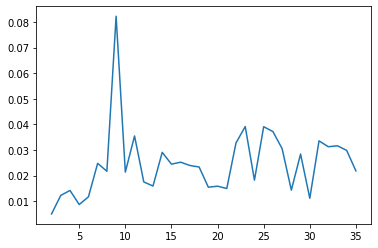

<class 'pandas.core.frame.DataFrame'> (10583, 9)
add_topic_names_to_df (10583,) (10583,)


In [51]:
batch_vectorizer = artm.BatchVectorizer(data_path=batch_folder,
                                        data_format='batches')


my_dictionary = artm.Dictionary()
my_dictionary.gather(data_path=batch_folder)

cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path=batch_folder,
    cooc_file_path=cooc_df_path,
    vocab_file_path=vocab_path,
)

num_of_records = len(topic_df)

max_num_topics = num_of_records // 100 +1
max_num_topics = max_num_topics if max_num_topics > 5 else 6
max_num_topics = max_num_topics if max_num_topics < 36 else 36

# max_num_topics = 5

coh_topics, big_models = check_num_topics(range(2, max_num_topics), my_dictionary, batch_vectorizer, cooc_dict)

plt.plot(coh_topics.keys(), coh_topics.values())
plt.show()

best_num_topics = max(coh_topics.items(), key=lambda x: x[1])[0]

topic_names = name_topics(big_models[best_num_topics])

try:
    best_topic_df = add_topic_names_to_df(big_models[best_num_topics], topic_df, 'label', topic_names)
except ValueError:
    print('BROKEN square', square_id)


In [52]:
best_topic_df.label.value_counts()

хороший_свой_ребёнок_любить_новый                    2266
петербург_питер_город_спб_россия                     1747
фоновая тема                                         1717
свой_делать_большой_сделать_дело                     1519
работа_цвет_цена_кожа_подарок                         886
музыка_концерт_вечер_театр_ресторан                   851
дом_питер_спб_квартира_весна                          642
искусство_изобразительный_проект_художник_картина     505
масло_машина_врач_минута_авто                         450
Name: label, dtype: int64

In [57]:
def save_topic_dict(file_path, model_artm, topic_names):
    topic_dict = {n: model_artm.score_tracker["top_words"].last_tokens[topic_name]
                 for (n, topic_name) in zip([topic_names[tt] for tt in model_artm.topic_names], model_artm.topic_names)}
   
    with open(file_path, 'wb') as handle:
        pickle.dump(topic_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return topic_dict

In [59]:
file_name = f'topic_dict_for_topic_dicts_2nd_level.pickle'
file_path = os.path.join(MAIN_DIR, file_name)
save_topic_dict(file_path, big_models[best_num_topics], topic_names)

{'работа_цвет_цена_кожа_подарок': ['работа',
  'цвет',
  'цена',
  'кожа',
  'подарок',
  'размер',
  'спб',
  'руб',
  'лицо',
  'торт',
  'ручной',
  'красивый',
  'татуировка',
  'рука',
  'любой',
  'чёрный',
  'платье',
  'осень',
  'наличие',
  'украшение',
  'магазин',
  'процедура',
  'стоимость',
  'мастер',
  'работать',
  'тат',
  'ресница',
  'губа',
  'рубль',
  'глаз',
  'крем',
  'белый',
  'сумка',
  'шоколад',
  'натуральный'],
 'дом_питер_спб_квартира_весна': ['дом',
  'питер',
  'спб',
  'квартира',
  'весна',
  'выходной',
  'отдых',
  'свадьба',
  'цветок',
  'мечта',
  'любимый',
  'купить',
  'новостройка',
  'март',
  'букет',
  'район',
  'жить',
  'лето',
  'недвижимость',
  'танец',
  'клуб',
  'свадебный',
  'продажа',
  'готовый',
  'проспект',
  'аренда',
  'застройщик',
  'жильё',
  'гулять',
  'элитный',
  'ресторан',
  'красота',
  'декор',
  'парк',
  'ремонт'],
 'хороший_свой_ребёнок_любить_новый': ['хороший',
  'свой',
  'ребёнок',
  'любить',
  'нов